In [1]:
import os
import geopandas as gpd
from tkinter import filedialog,messagebox
import tkinter as tk
import pandas as pd
import sys,os
import os
import traceback
from typing import Tuple

from helpers_linear_analysis import *
from helper_section_lines import *
from helpers_sectional_analysis import *
from helpers_plot import *

INPUT DATA

In [2]:
## output folder path
output_dir = "D:/2_Analytics/6_plan_vs_actual/13_oct_output_1"
os.makedirs(output_dir, exist_ok=True)

## actual data from site (excavation and dump)
actual_excavation_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Actual Dump & EXAVATION  area/Actual Excavated area.shp"
actual_dump_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Actual Dump & EXAVATION  area/Actual Dump area.shp"

## planned/proposed data from client 
planned_excavtaion_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Proposed Dump & Pit Area from client/Proposed PIT AREA from client.shp"
planned_dump_inputs = "D:/2_Analytics/6_plan_vs_actual/All_Inputs_UTCL/Proposed Dump & Pit Area from client/Proposed Dump from client.shp"


## dwg file and ODA convertor (to get section lines with attributes)
input_folder_dwg_file = "D:/2_Analytics/6_plan_vs_actual/raw_data_dwg_file/dwg_file"
oda_exe = "C:/Program Files/ODA/ODAFileConverter 26.7.0/ODAFileConverter.exe"

## Dtms
dtm_itr1_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/dtm_1/DEM_itr_1.tif"
itr_1 =  2024                              

dtm_itr2_path = "D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/dtm_2/DEM_itr_2.tif"
itr_2 = 2025                              

threshold = 2.5

Preprocess data for linear analysis --> Add required columns in input data and get epsg code to georeference the section line 

In [3]:
actual_excavation, actual_dump, planned_excavation, planned_dump, epsg_code =  get_data_preprocessed(
                                                                                        act_exv = actual_excavation_inputs, 
                                                                                        act_dump = actual_dump_inputs, 
                                                                                        pln_exv= planned_excavtaion_inputs, 
                                                                                        pln_dump= planned_dump_inputs, 
                                                                                        output_dir= output_dir
                                                                                        )


Get required outputs

In [4]:

results_exv, df_exv = split_planned_done_new(done_file= actual_excavation, 
                       planned_file= planned_excavation, 
                       output_dir= output_dir, 
                       area_type= "excavation" )


results_dump, df_dump = split_planned_done_new(done_file= actual_dump, 
                       planned_file= planned_dump, 
                       output_dir= output_dir, 
                       area_type= "dump") 

## merge the csv
excel_path = merge_and_save(df_exv, df_dump, output_dir)

# Save the pie chart and get df to append in final excel sheet 
df_excavation, img_path_excavation = plot_category_chart(output_dir, category="excavation", labels=None, colors=None, figsize=(4,4))
df_dump, img_path_dump = plot_category_chart(output_dir, category="dump", labels=None, colors=None, figsize=(4,4))

update_excel_with_tables_charts(
    input_excel = excel_path, 
    df_excavation = df_excavation, 
    img_path_excavation = img_path_excavation,
    df_dump=df_dump, 
    img_path_dump= img_path_dump
)

'D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\\merged_summary_updated.xlsx'

Get section lines from DWG file 

In [5]:
section_line_folder = os.path.join(output_dir, "section_lines")
os.makedirs(section_line_folder, exist_ok=True)
section_line_path = get_section_lines(input_folder= input_folder_dwg_file,
                                         section_line_folder= section_line_folder,
                                         oda_exe=oda_exe,
                                         crs = epsg_code)


 Selected layer: 'SECTION LINE NAUKARI LST'
   - Text count: 36
   - Entity total: 55
   - LINE: 5
   - LWPOLYLINE: 14
   - MTEXT: 36
 Saved as: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\section_lines\related_files\section_lines.dxf
Final line shapefile with start/end texts saved: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\section_lines\section_line.shp
Loaded 'D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\section_lines\section_line.shp' (18 features).
Column 'start_text': 5 changed cells.
Column 'end_text': 5 changed cells.
Backup of original shapefile written to: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\section_lines\section_line_bak


Get saved outputs from linear analysis 

In [6]:
(done_exv, unplanned_exv, done_dump, unplanned_dump) = get_linear_outputs(output_dir)
print(done_exv)
print(unplanned_exv)
print(done_dump)
print(unplanned_dump)

D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\shapefile_outputs\planned_and_done_excavation.shp
D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\shapefile_outputs\unplanned_and_done_excavation.shp
None
D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\shapefile_outputs\unplanned_and_done_dump.shp


In [ ]:
# --- helper to sanitize folder/filenames but keep spaces & apostrophes ---
def sanitize_keep_spaces_apostrophe(s: str) -> str:
    if s is None:
        return "section"
    s = str(s)
    s = s.replace("_", " ").strip()
    s = re.sub(r'[<>:"/\\|?*\n\r\t]+', "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s or "section"

# --- base output dir (you already set output_dir earlier) ---
output_folder_sectional_analysis = os.path.join(output_dir, "sectional_deviation_analysis")
os.makedirs(output_folder_sectional_analysis, exist_ok=True)

# read sections once
section_gdf = gpd.read_file(section_line_path)
n_sections = len(section_gdf)
print(f"Found {n_sections} sections in {section_line_path}")

for idx in range(n_sections):
    print(f"\n--- Processing section index {idx} ---")
    try:
        # read row and form section_name from your start_text & end_text columns
        row = section_gdf.iloc[idx]
        section_name_from_row = f"{row['start_text']}_{row['end_text']}"
        readable_section_name = sanitize_keep_spaces_apostrophe(section_name_from_row)  # e.g. "E E'"
        print("Section (from row):", section_name_from_row, "-> folder title:", readable_section_name)

        # create per-section folder (no numeric prefix) and required subfolders
        individual_section_folder = os.path.join(output_folder_sectional_analysis, readable_section_name)
        intersecting_lines_folder = os.path.join(individual_section_folder, "intersecting_lines")
        elevation_profile_folder = os.path.join(individual_section_folder, "elevation_profile")
        section_data_folder = os.path.join(individual_section_folder, "section_data")

        os.makedirs(intersecting_lines_folder, exist_ok=True)
        os.makedirs(elevation_profile_folder, exist_ok=True)
        os.makedirs(section_data_folder, exist_ok=True)

        # --- sample elevations for this section ---
        df = sample_elevations_two_dtms(
            dtm_path1=dtm_itr1_path,
            dtm_path2=dtm_itr2_path,
            section_gdf=section_gdf,
            section_number=idx,
            interval=0.01
        )

        # --- intersect polygons with this section line ---
        intersect_res = intersect_line_with_polygons_return_separately(
            line_gdf=section_gdf.iloc[[idx]],
            output_folder_path=intersecting_lines_folder,
            planned_and_done_excavation_path=done_exv,
            unplanned_and_done_excavation_path=unplanned_exv,
            planned_and_used_dump_path=done_dump,
            unplanned_and_used_dump_path=unplanned_dump
        )

        # flexible unpacking: function might return ((lines...), section_name) or ((lines...), section_name, folder)
        lines_planned_and_done_excavation = lines_unplanned_and_done_excavation = None
        lines_planned_and_used_dump = lines_unplanned_and_used_dump = None
        returned_section_name = None

        if isinstance(intersect_res, tuple):
            if len(intersect_res) == 2:
                lines_tuple, returned_section_name = intersect_res
            elif len(intersect_res) == 3:
                lines_tuple, returned_section_name, ret_folder = intersect_res
            else:
                lines_tuple = intersect_res[0]
            try:
                (lines_planned_and_done_excavation,
                 lines_unplanned_and_done_excavation,
                 lines_planned_and_used_dump,
                 lines_unplanned_and_used_dump) = lines_tuple
            except Exception:
                print("Warning: couldn't unpack lines tuple from intersect result; proceeding with None line_gdfs.")
        else:
            print("Warning: intersect_line_with_polygons_return_separately returned unexpected type:", type(intersect_res))

        # prefer returned name if present
        if returned_section_name:
            section_name_for_title = returned_section_name
        else:
            section_name_for_title = section_name_from_row

        # --- prepare CSV path in section_data folder ---
        csv_path = os.path.join(section_data_folder, "section_data.csv")

        # --- add labels for planned/unplanned areas ---
        df_1 = add_labels_for_planned_area(
            df,
            line_gdf=lines_planned_and_done_excavation,
            key="planned_and_done_excavation",
            output_csv=csv_path
        )

        df_2 = add_labels_for_planned_area(
            df_1,
            line_gdf=lines_planned_and_used_dump,
            key="planned_and_used_dump",
            output_csv=csv_path
        )

        df_3 = add_labels_for_unplanned_area(
            section_df=df_2,
            line_gdf=lines_unplanned_and_done_excavation,
            key="unplanned_and_done_excavation",
            threshold=threshold,
            output_csv=csv_path
        )

        df_4 = add_labels_for_unplanned_area(
            section_df=df_3,
            line_gdf=lines_unplanned_and_used_dump,
            key="unplanned_and_used_dump",
            threshold=threshold,
            output_csv=csv_path
        )

        # --- build PNG filepath and save plot into elevation_profile folder ---
        png_filename = f"elevation_profile {sanitize_keep_spaces_apostrophe(section_name_for_title)}.png"
        png_filename = re.sub(r'[<>:"/\\|?*\n\r\t]+', "", png_filename).strip()
        save_file_path = os.path.join(elevation_profile_folder, png_filename)

        # call plotting function (pass a full file path, not a folder)
        plot_planned_and_unplanned_areas_with_numbered_legend(
            df_4,
            itr1=itr_1,
            itr2=itr_2,
            section_name=section_name_for_title,
            save_path=save_file_path,
            show=False
        )

        print(f"Saved files for section '{readable_section_name}':")
        print(" - shapefiles (if any) ->", intersecting_lines_folder)
        print(" - csv ->", csv_path)
        print(" - png ->", save_file_path)

    except Exception as e:
        # print traceback and stop immediately by re-raising
        print(f"Error processing section idx {idx}: {e}")
        traceback.print_exc()
        raise


Found 18 sections in D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\section_lines\section_line.shp

--- Processing section index 0 ---
Section (from row): E_E' -> folder title: E E'
E_E'
D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\intersecting_lines\section_E_E'_planned_and_done_excavation.shp
D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\intersecting_lines\section_E_E'_unplanned_and_done_excavation.shp
D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\intersecting_lines\section_E_E'_planned_and_used_dump.shp
planned_and_used_dump: File path is None or does not exist.
D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\intersecting_lines\section_E_E'_unplanned_and_used_dump.shp
unplanned_and_used_dump: No intersection.


d:\Github\Plan_vs_actual_automation\deviation_analysis_automation\deviation_analysis_2\helpers_sectional_analysis.py:224: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'planned_and_done_excavation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  section_df.loc[mask, "line_name"] = key


Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Skipped: line_gdf has no features for key 'planned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Removed label for 'unplanned_and_done_excavation' at feature 1: no elevation diff > 2.5
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Skipped: line_gdf has no features for key 'unplanned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Saved files for section 'E E'':
 - shapefiles (if any) -> D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\sectional_deviation_analysis\E E'\intersecting_lines
 - csv -> D:/2_Analytics/6_plan_vs_actual/13_

        chainage              x             y      z_itr1      z_itr2
0           0.00  306068.317569  2.189345e+06  217.932388  218.372177
1           0.01  306068.320954  2.189345e+06  217.932388  218.372177
2           0.02  306068.324338  2.189345e+06  217.937790  218.372177
3           0.03  306068.327723  2.189345e+06  217.937790  218.372177
4           0.04  306068.331107  2.189345e+06  217.937790  218.372177
...          ...            ...           ...         ...         ...
154205   1542.05  306590.235336  2.190796e+06  195.482040  195.579559
154206   1542.06  306590.238721  2.190796e+06  195.482040  195.579559
154207   1542.07  306590.242105  2.190796e+06  195.482040  195.579559
154208   1542.08  306590.245490  2.190796e+06  195.484009  195.579559
154209   1542.09  306590.247178  2.190796e+06  195.484009  195.579559

[154210 rows x 5 columns]
E_E'
D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\section_E_E'_planned_and_done_excavati

d:\1_code\code_plane_vs_actual\deviation_analysis_2\helpers_sectional_analysis.py:225: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'planned_and_done_excavation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  section_df.loc[mask, "line_name"] = key


Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\section_data.csv
Skipped: line_gdf has no features for key 'planned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\section_data.csv
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\section_data.csv
Skipped: line_gdf has no features for key 'unplanned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\section_data.csv


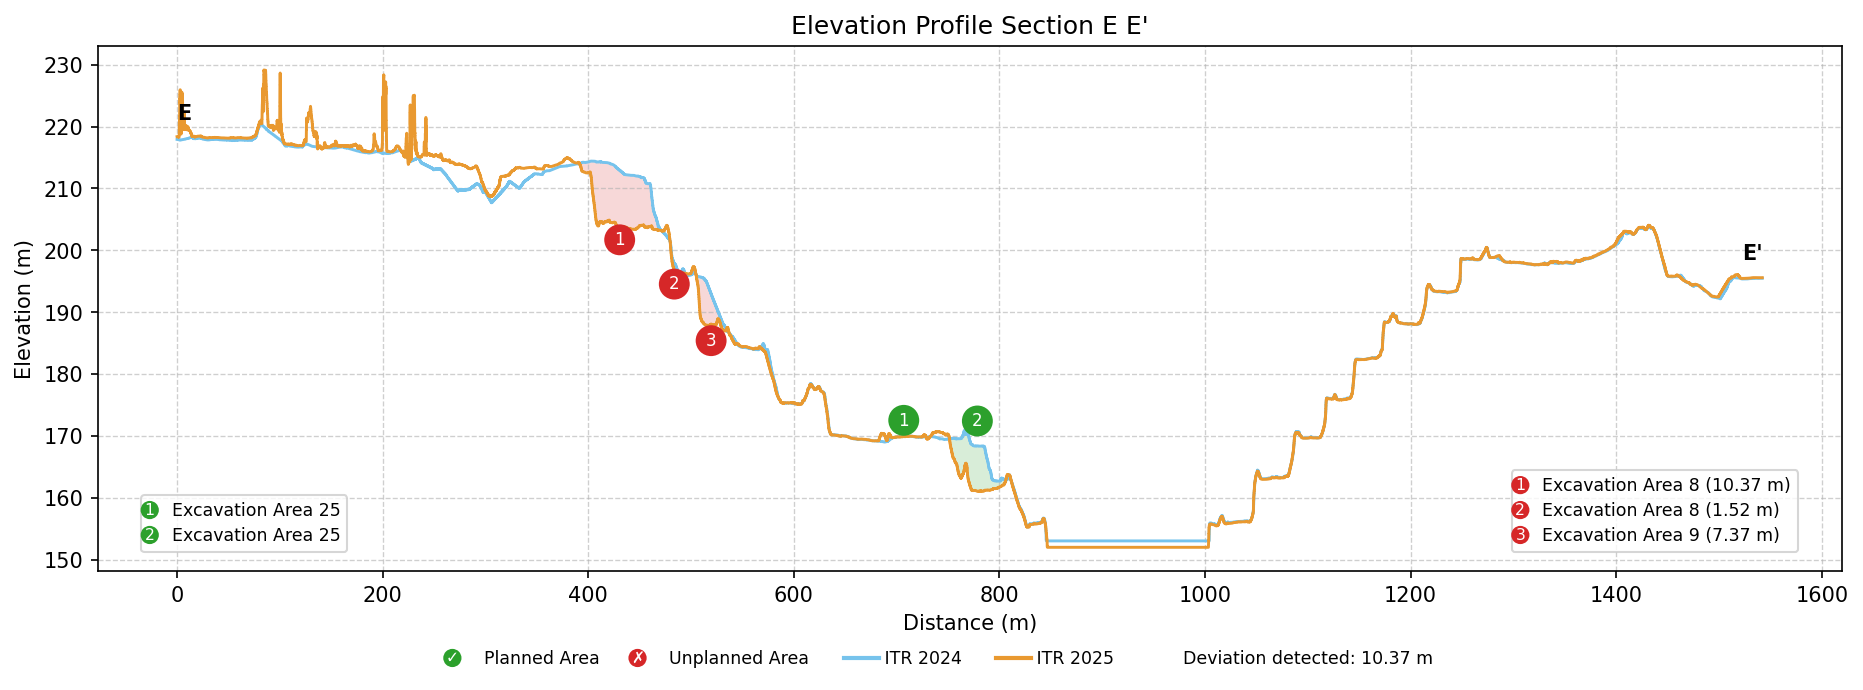

(<Figure size 2250x750 with 1 Axes>,
 <Axes: title={'center': "Elevation Profile Section E E'"}, xlabel='Distance (m)', ylabel='Elevation (m)'>)

In [8]:
section_number = 0
threshold = 1

section_gdf = gpd.read_file(section_line_path)
output_folder_sectional_analysis = os.path.join(output_dir,"sectional_deviation_analysis")
os.makedirs(output_folder_sectional_analysis, exist_ok=True)


df = sample_elevations_two_dtms(
    dtm_path1=dtm_itr1_path,
    dtm_path2=dtm_itr2_path,
    section_gdf=section_gdf,
    section_number = section_number,
    interval=0.01
)

print(df)


(   lines_planned_and_done_excavation,
    lines_unplanned_and_done_excavation,
    lines_planned_and_used_dump,
    lines_unplanned_and_used_dump  ), section_name, individual_section_folder = intersect_line_with_polygons_return_separately(
                                                    line_gdf=section_gdf.iloc[[section_number]],
                                                    output_folder_path= output_folder_sectional_analysis,
                                                    planned_and_done_excavation_path = done_exv,
                                                    unplanned_and_done_excavation_path = unplanned_exv,
                                                    planned_and_used_dump_path = done_dump,
                                                    unplanned_and_used_dump_path  = unplanned_dump)   

print(section_name)


csv_path = os.path.join(individual_section_folder,"section_data.csv")


df_1 = add_labels_for_planned_area(
                                    df,
                                    line_gdf=lines_planned_and_done_excavation,  # can be None or empty too
                                    key="planned_and_done_excavation",
                                    output_csv= csv_path
                                    )

df_2 = add_labels_for_planned_area(
                                    df_1,
                                    line_gdf=lines_planned_and_used_dump,  # can be None or empty too
                                    key="planned_and_used_dump",
                                    output_csv=csv_path
                                    )


df_3 = add_labels_for_unplanned_area(
                                    section_df=df_2,
                                    line_gdf=lines_unplanned_and_done_excavation,
                                    key="unplanned_and_done_excavation",
                                    threshold=threshold,  
                                    output_csv=csv_path
)


df_4 = add_labels_for_unplanned_area(
                                    section_df=df_3,
                                    line_gdf=lines_unplanned_and_used_dump,
                                    key="unplanned_and_used_dump",
                                    threshold=threshold,  
                                    output_csv=csv_path
                                    )

plot_planned_and_unplanned_areas_with_numbered_legend(df_4, 
                                                      itr1 = itr_1, 
                                                      itr2 = itr_2, 
                                                      section_name=section_name,
                                                      save_path = individual_section_folder)

In [11]:
output_folder_sectional_analysis = os.path.join(output_dir, "sectional_deviation_analysis")
os.makedirs(output_folder_sectional_analysis, exist_ok=True)

# read sections once
section_gdf = gpd.read_file(section_line_path)
n_sections = len(section_gdf)
print(f"Found {n_sections} sections in {section_line_path}")

for idx in range(n_sections):
    print(f"\n--- Processing section index {idx} ---")
    try:
        row = section_gdf.iloc[idx]                       
        section_name = f"{row['start_text']}_{row['end_text']}"
        print(section_name)
        
        individual_section_folder = os.path.join(output_folder_sectional_analysis, f"section_{section_name}")
        os.makedirs(individual_section_folder, exist_ok=True)

        ## get the elevations from both itrs on section
        df = sample_elevations_two_dtms(
        dtm_path1=dtm_itr1_path,
        dtm_path2=dtm_itr2_path,
        section_gdf=section_gdf,
        section_number = idx,
        interval=0.01
        )

        output_folder_intersecting_lines = os.path.join(individual_section_folder, "intersecting_lines")
        os.makedirs(individual_section_folder, exist_ok=True)
        
        ## intersect polygons with line and fetch line data
        (lines_planned_and_done_excavation,
        lines_unplanned_and_done_excavation,
        lines_planned_and_used_dump,
        lines_unplanned_and_used_dump  ), section_name = intersect_line_with_polygons_return_separately(
                                                                                    line_gdf=section_gdf.iloc[[idx]],
                                                                                    output_folder_path= output_folder_intersecting_lines,
                                                                                    planned_and_done_excavation_path = done_exv,
                                                                                    unplanned_and_done_excavation_path = unplanned_exv,
                                                                                    planned_and_used_dump_path = done_dump,
                                                                                    unplanned_and_used_dump_path  = unplanned_dump)
        print(lines_planned_and_done_excavation)

        csv_path = os.path.join(individual_section_folder,"section_data.csv")



        df_1 = add_labels_for_planned_area(
                                            df,
                                            line_gdf=lines_planned_and_done_excavation,  # can be None or empty too
                                            key="planned_and_done_excavation",
                                            output_csv= csv_path
                                            )

        df_2 = add_labels_for_planned_area(
                                            df_1,
                                            line_gdf=lines_planned_and_used_dump,  # can be None or empty too
                                            key="planned_and_used_dump",
                                            output_csv=csv_path
                                            )


        df_3 = add_labels_for_unplanned_area(
                                            section_df=df_2,
                                            line_gdf=lines_unplanned_and_done_excavation,
                                            key="unplanned_and_done_excavation",
                                            threshold=threshold,  
                                            output_csv=csv_path
        )


        df_4 = add_labels_for_unplanned_area(
                                            section_df=df_3,
                                            line_gdf=lines_unplanned_and_used_dump,
                                            key="unplanned_and_used_dump",
                                            threshold=threshold,  
                                            output_csv=csv_path
                                            )

        plot_planned_and_unplanned_areas_with_numbered_legend(df_4, 
                                                            itr1 = itr_1, 
                                                            itr2 = itr_2, 
                                                            section_name=section_name,
                                                            save_path = individual_section_folder)
                


    except Exception as e:
        print(f"Error processing section idx {idx}: {e}")
        traceback.print_exc()
        continue
            



Found 18 sections in D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\section_lines\section_line.shp

--- Processing section index 0 ---
E_E'
E_E'
D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\intersecting_lines\section_E_E'_planned_and_done_excavation.shp
Error processing section idx 0: Failed to create file D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\intersecting_lines/section_E_E'_planned_and_done_excavation.shp: No such file or direct

--- Processing section index 1 ---
J_J'


Traceback (most recent call last):
  File "pyogrio\\_io.pyx", line 2315, in pyogrio._io.create_ogr_dataset_layer
  File "pyogrio\\_err.pyx", line 218, in pyogrio._err.check_pointer
pyogrio._err.CPLE_AppDefinedError: Failed to create file D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\section_E_E'\intersecting_lines/section_E_E'_planned_and_done_excavation.shp: No such file or direct

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_16476\2634124118.py", line 35, in <module>
    lines_unplanned_and_used_dump  ), section_name = intersect_line_with_polygons_return_separately(
  File "d:\1_code\code_plane_vs_actual\deviation_analysis_2\helpers_sectional_analysis.py", line 158, in intersect_line_with_polygons_return_separately
    lines_planned_and_done_excavation = process("planned_and_done_excavation", planned_and_done_excavation_path, output

KeyboardInterrupt: 

In [12]:
threshold = 1

# --- helper to sanitize folder/filenames but keep spaces & apostrophes ---
def sanitize_keep_spaces_apostrophe(s: str) -> str:
    if s is None:
        return "section"
    s = str(s)
    # replace underscores with space for readability (you already use start_text/end_text)
    s = s.replace("_", " ").strip()
    # remove illegal filesystem chars but keep spaces and apostrophes
    s = re.sub(r'[<>:"/\\|?*\n\r\t]+', "", s)
    # collapse multiple spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s or "section"

# --- base output dir (you already set output_dir earlier) ---
output_folder_sectional_analysis = os.path.join(output_dir, "sectional_deviation_analysis")
os.makedirs(output_folder_sectional_analysis, exist_ok=True)

# read sections once
section_gdf = gpd.read_file(section_line_path)
n_sections = len(section_gdf)
print(f"Found {n_sections} sections in {section_line_path}")

for idx in range(n_sections):
    print(f"\n--- Processing section index {idx} ---")
    try:
        # read row and form section_name from your start_text & end_text columns
        row = section_gdf.iloc[idx]
        section_name_from_row = f"{row['start_text']}_{row['end_text']}"
        readable_section_name = sanitize_keep_spaces_apostrophe(section_name_from_row)  # e.g. "E E'"
        print("Section (from row):", section_name_from_row, "-> folder title:", readable_section_name)

        # create per-section folder (no numeric prefix) and required subfolders
        individual_section_folder = os.path.join(output_folder_sectional_analysis, readable_section_name)
        intersecting_lines_folder = os.path.join(individual_section_folder, "intersecting_lines")
        elevation_profile_folder = os.path.join(individual_section_folder, "elevation_profile")
        section_data_folder = os.path.join(individual_section_folder, "section_data")

        os.makedirs(intersecting_lines_folder, exist_ok=True)
        os.makedirs(elevation_profile_folder, exist_ok=True)
        os.makedirs(section_data_folder, exist_ok=True)

        # --- sample elevations for this section ---
        df = sample_elevations_two_dtms(
            dtm_path1=dtm_itr1_path,
            dtm_path2=dtm_itr2_path,
            section_gdf=section_gdf,
            section_number=idx,
            interval=0.01
        )

        # --- intersect polygons with this section line ---
        # pass the per-section intersecting_lines_folder so shapefiles (if any) go there
        intersect_res = intersect_line_with_polygons_return_separately(
            line_gdf=section_gdf.iloc[[idx]],
            output_folder_path=intersecting_lines_folder,
            planned_and_done_excavation_path=done_exv,
            unplanned_and_done_excavation_path=unplanned_exv,
            planned_and_used_dump_path=done_dump,
            unplanned_and_used_dump_path=unplanned_dump
        )

        # flexible unpacking: function might return ((lines...), section_name) or ((lines...), section_name, folder)
        lines_planned_and_done_excavation = lines_unplanned_and_done_excavation = None
        lines_planned_and_used_dump = lines_unplanned_and_used_dump = None
        returned_section_name = None

        if isinstance(intersect_res, tuple):
            if len(intersect_res) == 2:
                lines_tuple, returned_section_name = intersect_res
            elif len(intersect_res) == 3:
                lines_tuple, returned_section_name, ret_folder = intersect_res
            else:
                # Unexpected shape but try best-effort: assume first element holds the lines tuple
                lines_tuple = intersect_res[0]
            # unpack lines tuple if present
            try:
                (lines_planned_and_done_excavation,
                 lines_unplanned_and_done_excavation,
                 lines_planned_and_used_dump,
                 lines_unplanned_and_used_dump) = lines_tuple
            except Exception:
                # if unpack fails, just print and continue with None values
                print("Warning: couldn't unpack lines tuple from intersect result; proceeding with None line_gdfs.")
        else:
            # not a tuple result — warn and continue
            print("Warning: intersect_line_with_polygons_return_separately returned unexpected type:", type(intersect_res))

        # If intersect returned a section name, prefer it for plot title; else use row-derived name
        if returned_section_name:
            section_name_for_title = returned_section_name
        else:
            # revert to underscore form for the function expecting underscores e.g. "E_E'"
            section_name_for_title = section_name_from_row

        # --- prepare CSV path in section_data folder ---
        csv_path = os.path.join(section_data_folder, "section_data.csv")

        # --- add labels for planned/unplanned areas (these write to csv_path if implemented) ---
        df_1 = add_labels_for_planned_area(
            df,
            line_gdf=lines_planned_and_done_excavation,
            key="planned_and_done_excavation",
            output_csv=csv_path
        )

        df_2 = add_labels_for_planned_area(
            df_1,
            line_gdf=lines_planned_and_used_dump,
            key="planned_and_used_dump",
            output_csv=csv_path
        )

        df_3 = add_labels_for_unplanned_area(
            section_df=df_2,
            line_gdf=lines_unplanned_and_done_excavation,
            key="unplanned_and_done_excavation",
            threshold=threshold,
            output_csv=csv_path
        )

        df_4 = add_labels_for_unplanned_area(
            section_df=df_3,
            line_gdf=lines_unplanned_and_used_dump,
            key="unplanned_and_used_dump",
            threshold=threshold,
            output_csv=csv_path
        )

        # --- build PNG filepath and save plot into elevation_profile folder ---
        png_filename = f"elevation_profile {sanitize_keep_spaces_apostrophe(section_name_for_title)}.png"
        png_filename = re.sub(r'[<>:"/\\|?*\n\r\t]+', "", png_filename).strip()
        save_file_path = os.path.join(elevation_profile_folder, png_filename)

        # call plotting function (pass a full file path, not a folder)
        plot_planned_and_unplanned_areas_with_numbered_legend(
            df_4,
            itr1=itr_1,
            itr2=itr_2,
            section_name=section_name_for_title,
            save_path=save_file_path,
            show=False
        )

        print(f"Saved files for section '{readable_section_name}':")
        print(" - shapefiles (if any) ->", intersecting_lines_folder)
        print(" - csv ->", csv_path)
        print(" - png ->", save_file_path)

    except Exception as e:
        print(f"Error processing section idx {idx}: {e}")
        traceback.print_exc()
        continue

print("Done processing all sections.")


Found 18 sections in D:/2_Analytics/6_plan_vs_actual/13_oct_output_1\section_lines\section_line.shp

--- Processing section index 0 ---
Section (from row): E_E' -> folder title: E E'
Error processing section idx 0: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory

--- Processing section index 1 ---
Section (from row): J_J' -> folder title: J J'
Error processing section idx 1: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory

--- Processing section index 2 ---
Section (from row): C_C' -> folder title: C C'
Error processing section idx 2: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory

--- Processing section index 3 ---
Section (from row): N_N' -> folder title: N N'
Error processing section idx 3: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory

--- Processing section index 4 ---
Section (fro

Traceback (most recent call last):
  File "rasterio\\_base.pyx", line 310, in rasterio._base.DatasetBase.__init__
  File "rasterio\\_base.pyx", line 221, in rasterio._base.open_dataset
  File "rasterio\\_err.pyx", line 359, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_13676\1374005951.py", line 45, in <module>
    df = sample_elevations_two_dtms(
        dtm_path1=dtm_itr1_path,
    ...<3 lines>...
        interval=0.01
    )
  File "d:\Github\Plan_vs_actual_automation\deviation_analysis_automation\deviation_analysis_2\helpers_sectional_analysis.py", line 74, in sample_elevations_two_dtms
    with rasterio.open(dtm_path1) as dtm1, rasterio.open(dtm_path2) as dtm2:
         ~~~~~~~~~~~~~^^^^^^^^^^^
 

Error processing section idx 17: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory
Done processing all sections.


Traceback (most recent call last):
  File "rasterio\\_base.pyx", line 310, in rasterio._base.DatasetBase.__init__
  File "rasterio\\_base.pyx", line 221, in rasterio._base.open_dataset
  File "rasterio\\_err.pyx", line 359, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: D:/2_Analytics/6_plan_vs_actual/UTCL_data/UTCL_data/DEMs/DEM_itr_1.tif: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\MansiPradipKoshti\AppData\Local\Temp\ipykernel_13676\1374005951.py", line 45, in <module>
    df = sample_elevations_two_dtms(
        dtm_path1=dtm_itr1_path,
    ...<3 lines>...
        interval=0.01
    )
  File "d:\Github\Plan_vs_actual_automation\deviation_analysis_automation\deviation_analysis_2\helpers_sectional_analysis.py", line 74, in sample_elevations_two_dtms
    with rasterio.open(dtm_path1) as dtm1, rasterio.open(dtm_path2) as dtm2:
         ~~~~~~~~~~~~~^^^^^^^^^^^
 

Found 18 sections in D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\section_lines\section_line.shp

--- Processing section index 0 ---
E_E'
D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\temp_intersect\section_E_E'\section_E_E'_planned_and_done_excavation.shp
D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\temp_intersect\section_E_E'\section_E_E'_unplanned_and_done_excavation.shp
D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\temp_intersect\section_E_E'\section_E_E'_planned_and_used_dump.shp
planned_and_used_dump: File path is None or does not exist.
D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\temp_intersect\section_E_E'\section_E_E'_unplanned_and_used_dump.shp
unplanned_and_used_dump: No intersection.
Section name (readable): 'E E'' -> folder: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\E E'


d:\1_code\code_plane_vs_actual\deviation_analysis_2\helpers_sectional_analysis.py:225: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'planned_and_done_excavation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  section_df.loc[mask, "line_name"] = key


Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Skipped: line_gdf has no features for key 'planned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Removed label for 'unplanned_and_done_excavation' at feature 1: no elevation diff > 2
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Skipped: line_gdf has no features for key 'unplanned_and_used_dump'.
Updated DataFrame exported to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\E E'\section_data\section_data.csv
Saved plot to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\sectional_deviation_analysis\E E'\elevation_profile\elevation_profile E E'.png
Saved CSV to: D:/2_Analytics/6_plan_vs_actual/17_sep_output_1\se

KeyboardInterrupt: 

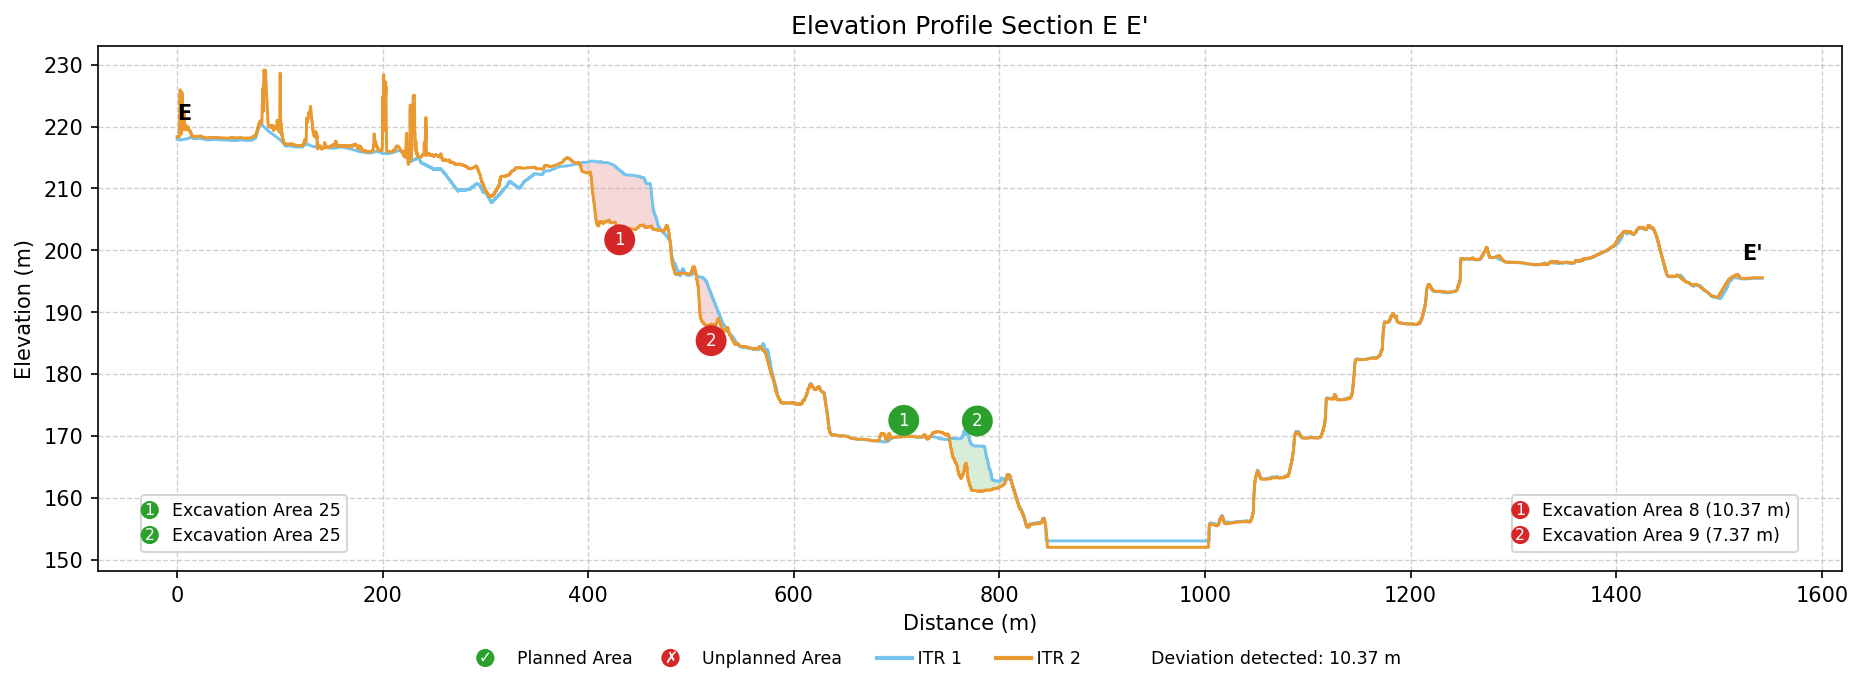

In [10]:
# # your existing functions are assumed imported:
# # sample_elevations_two_dtms
# # intersect_line_with_polygons_return_separately
# # add_labels_for_planned_area
# # add_labels_for_unplanned_area
# # plot_planned_and_unplanned_areas_with_numbered_legend

# # Inputs you already have
# dtm_itr1_path = "<path to itr1 dtm>"
# dtm_itr2_path = "<path to itr2 dtm>"
# section_line_path = "<path to sections geojson/shp>"
# done_exv = "<planned_and_done_excavation polygon path>"
# unplanned_exv = "<unplanned_and_done_excavation polygon path>"
# done_dump = "<planned_and_used_dump polygon path>"
# unplanned_dump = "<unplanned_and_used_dump polygon path>"
# output_dir = "<base output dir>"


itr_1 = "1"
itr_2 = "2"
threshold = 2
interval = 0.01

# helper to make a safe folder name but preserve spaces and apostrophes
def safe_section_folder_name(raw_section_name: str) -> str:
    if raw_section_name is None:
        raw_section_name = "section"
    # replace underscores with spaces for readability
    readable = raw_section_name.replace("_", " ").strip()
    # remove characters illegal in filenames but KEEP spaces and apostrophes
    safe = re.sub(r'[<>:"/\\|?*\n\r\t]+', "", readable)
    # collapse multiple spaces to single and strip
    safe = re.sub(r"\s+", " ", safe).strip()
    # fallback if empty
    return safe or "section"

# make master output dir
output_folder_sectional_analysis = os.path.join(output_dir, "sectional_deviation_analysis")
os.makedirs(output_folder_sectional_analysis, exist_ok=True)

# read sections once
section_gdf = gpd.read_file(section_line_path)
n_sections = len(section_gdf)
print(f"Found {n_sections} sections in {section_line_path}")

for idx in range(n_sections):
    print(f"\n--- Processing section index {idx} ---")
    try:
        # sample elevations for this section
        df = sample_elevations_two_dtms(
            dtm_path1=dtm_itr1_path,
            dtm_path2=dtm_itr2_path,
            section_gdf=section_gdf,
            section_number=idx,
            interval=interval
        )

        # Get the returned section name from intersect function.
        # We will create the section folder based on that name (no numeric prefix).
        # Create a temporary shapefile output folder first and pass it in.
        # We'll create the top-level section folder after we know section_name.
        # Use a short temp folder under master output to avoid conflicts
        temp_base = os.path.join(output_folder_sectional_analysis, "temp_intersect")
        os.makedirs(temp_base, exist_ok=True)

        (lines_planned_and_done_excavation,
         lines_unplanned_and_done_excavation,
         lines_planned_and_used_dump,
         lines_unplanned_and_used_dump), section_name, _ = (
            intersect_line_with_polygons_return_separately(
                line_gdf=section_gdf.iloc[[idx]],
                output_folder_path=temp_base,   # we'll move or ignore later
                planned_and_done_excavation_path=done_exv,
                unplanned_and_done_excavation_path=unplanned_exv,
                planned_and_used_dump_path=done_dump,
                unplanned_and_used_dump_path=unplanned_dump
            )
        )

        # Make readable section name (E_E' -> "E E'")
        readable_section_name = section_name.replace("_", " ") if section_name else "section"

        # Build the section folder (no numeric prefix). Sanitize the folder name but keep spaces and apostrophes.
        section_folder_name = safe_section_folder_name(section_name)
        individual_section_folder = os.path.join(output_folder_sectional_analysis, section_folder_name)
        os.makedirs(individual_section_folder, exist_ok=True)

        # Create required subfolders
        shapefiles_output = os.path.join(individual_section_folder, "shapefiles_output")
        elevation_profile_folder = os.path.join(individual_section_folder, "elevation_profile")
        section_data_folder = os.path.join(individual_section_folder, "section_data")
        os.makedirs(shapefiles_output, exist_ok=True)
        os.makedirs(elevation_profile_folder, exist_ok=True)
        os.makedirs(section_data_folder, exist_ok=True)

        # If intersect function wrote shapefiles into temp_base, move them into shapefiles_output
        # (optional) — try to move files created in temp_base -> shapefiles_output
        try:
            for fname in os.listdir(temp_base):
                src = os.path.join(temp_base, fname)
                dst = os.path.join(shapefiles_output, fname)
                # avoid overwriting existing files unintentionally
                if os.path.exists(dst):
                    # add suffix if exists
                    base, ext = os.path.splitext(fname)
                    i = 1
                    while os.path.exists(os.path.join(shapefiles_output, f"{base}_{i}{ext}")):
                        i += 1
                    dst = os.path.join(shapefiles_output, f"{base}_{i}{ext}")
                os.replace(src, dst)
        except Exception:
            # ignore move errors; temp files may not exist or intersect function may not have created them
            pass

        print(f"Section name (readable): '{readable_section_name}' -> folder: {individual_section_folder}")

        # CSV path inside section_data folder
        csv_path = os.path.join(section_data_folder, "section_data.csv")

        # add planned labels
        df_1 = add_labels_for_planned_area(
            df,
            line_gdf=lines_planned_and_done_excavation,
            key="planned_and_done_excavation",
            output_csv=csv_path
        )

        df_2 = add_labels_for_planned_area(
            df_1,
            line_gdf=lines_planned_and_used_dump,
            key="planned_and_used_dump",
            output_csv=csv_path
        )

        # add unplanned labels
        df_3 = add_labels_for_unplanned_area(
            section_df=df_2,
            line_gdf=lines_unplanned_and_done_excavation,
            key="unplanned_and_done_excavation",
            threshold=threshold,
            output_csv=csv_path
        )

        df_4 = add_labels_for_unplanned_area(
            section_df=df_3,
            line_gdf=lines_unplanned_and_used_dump,
            key="unplanned_and_used_dump",
            threshold=threshold,
            output_csv=csv_path
        )

        # Build a filename-safe version of readable_section_name for the PNG (keep spaces and apostrophes)
        png_name = f"elevation_profile {readable_section_name}.png"
        # sanitize only illegal filename chars but keep spaces and apostrophes
        png_name = re.sub(r'[<>:"/\\|?*\n\r\t]+', "", png_name).strip()
        save_file_path = os.path.join(elevation_profile_folder, png_name)

        # plot and save (pass full file path). Use show=False when running many.
        fig, ax = plot_planned_and_unplanned_areas_with_numbered_legend(
            df_4,
            itr1=itr_1,
            itr2=itr_2,
            section_name=section_name,
            save_path=save_file_path,
            show=False
        )
        print(f"Saved plot to: {save_file_path}")
        print(f"Saved CSV to: {csv_path} (if your functions wrote it)")

    except Exception as e:
        print(f"Error processing section idx {idx}: {e}")
        traceback.print_exc()
        continue

# cleanup temp folder if desired
try:
    if os.path.exists(temp_base):
        # remove if empty; if not empty, you can remove manually or keep for inspection
        os.rmdir(temp_base)
except Exception:
    pass

print("Done processing all sections.")
